## Preprocessing

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from flask import session
from app import app
from models import db
from models.telemetry import TelemetryData

In [3]:
from utils.packet_parser import parse_csv, parse_cc2dc_packet

In [4]:
# Step 1: Load all CSV files in the 'attack' directory
attack_dir = "attack"
dataframes = []
with app.app_context():
    for idx, file in enumerate(os.listdir(attack_dir)):
        if file.endswith(".csv"):
            file_path = os.path.join(attack_dir, file)
            attack_type = ''.join([char for char in file.split('.')[0] if not char.isdigit()])
            try:
                # Parse the CSV file using the packet parser
                parsed_data = parse_csv(file_path)
                # Convert parsed data into a DataFrame
                df = pd.DataFrame(parsed_data)
                df['Filenumber'] = idx  # Add a column for the file number
                df['Attack_Type'] = attack_type  # Add a column for the attack type
                dataframes.append(df)
            except Exception as e:
                print(f"Error parsing {file_path}: {e}")

In [5]:
# Combine all data into a single DataFrame
all_data = pd.concat(dataframes, ignore_index=True)
display(all_data)

,CC_Name,Timestamp,Stats,Filenumber,Attack_Type
0,cc1,2025-04-14T18:26:55.147,"{'a2:52:97:90:05:d9': {'Number of Ports': '6',...",0,udp
1,cc1,2025-04-14T18:26:59.532,"{'a2:52:97:90:05:d9': {'Number of Ports': '6',...",0,udp
2,cc1,2025-04-14T18:27:04.005,"{'a2:52:97:90:05:d9': {'Number of Ports': '6',...",0,udp
3,cc1,2025-04-14T18:27:08.445,"{'a2:52:97:90:05:d9': {'Number of Ports': '6',...",0,udp
4,cc1,2025-04-14T18:27:12.912,"{'a2:52:97:90:05:d9': {'Number of Ports': '6',...",0,udp
...,...,...,...,...,...
427,cc1,2025-04-14T18:44:43.281,"{'4a:b3:d8:11:48:48': {'Number of Ports': '6',...",73,syn
428,cc1,2025-04-14T18:44:47.672,"{'4a:b3:d8:11:48:48': {'Number of Ports': '6',...",73,syn
429,cc1,2025-04-14T18:44:52.212,"{'4a:b3:d8:11:48:48': {'Number of Ports': '6',...",73,syn
430,cc1,2025-04-14T18:44:56.738,"{'4a:b3:d8:11:48:48': {'Number of Ports': '6',...",73,syn


In [6]:
all_data['Stats'] = all_data['Stats'].apply(
    lambda x: list(x.values())[0] if isinstance(x, dict) and len(x) > 0 else None
)
stats_data = pd.json_normalize(all_data['Stats'])
all_data_flattened = pd.concat([all_data.drop(columns=['Stats']), stats_data], axis=1)
display(all_data_flattened)

,CC_Name,Timestamp,Filenumber,Attack_Type,Number of Ports,Latest Timestamp,Oldest Timestamp,Total Packets,Total Bytes,Total Errors,...,Average Rx Packets,Average Rx Bytes,Average Rx Errors,Average Tx Packets,Average Tx Bytes,Average Tx Errors,Average Rx Utilization,Average Tx Utilization,Average Throughput (Mbps),Average Buffer Occupancy
0,cc1,2025-04-14T18:26:55.147,0,udp,6,2025-04-14 18:26:53.340000,2025-04-14 18:26:51.405000,2.8679303603095443,2792.166747297956,0.0,...,0.0,0.002843021195098926,0.0,0.0,0.2820702754060821,234.44668150208807,0.0,0.19591811797884193,230.91444304757124,0.0
1,cc1,2025-04-14T18:26:59.532,0,udp,6,2025-04-14 18:26:57.710000,2025-04-14 18:26:56.206000,3.390573623718412,3278.443188122358,0.0,...,0.0,0.00364399666686537,0.0,0.0,0.33796137659431674,275.4755555695255,0.0,0.2271342273587519,270.9316424508674,0.0
2,cc1,2025-04-14T18:27:04.005,0,udp,6,2025-04-14 18:27:02.114000,2025-04-14 18:27:00.618000,3.7436877860512663,3418.3648167637966,0.0,...,0.0,0.0038827247018605763,0.0,0.0,0.22602179025790878,278.84708129640427,0.0,0.39792617408396896,290.88038816422846,0.0
3,cc1,2025-04-14T18:27:08.445,0,udp,6,2025-04-14 18:27:06.625000,2025-04-14 18:27:06.625000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,cc1,2025-04-14T18:27:12.912,0,udp,6,2025-04-14 18:27:09.521000,2025-04-14 18:27:09.521000,1.7268945777217102,1024.739242420063,0.0,...,0.0,0.0020211574137654897,0.0,0.0,0.172689457772171,86.5749814964484,0.0,0.11512630518144734,84.21489224022874,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,cc1,2025-04-14T18:44:43.281,73,syn,6,2025-04-14 18:44:41.368000,2025-04-14 18:44:41.368000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
428,cc1,2025-04-14T18:44:47.672,73,syn,6,2025-04-14 18:44:45.868000,2025-04-14 18:44:45.868000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
429,cc1,2025-04-14T18:44:52.212,73,syn,6,2025-04-14 18:44:50.271000,2025-04-14 18:44:48.756000,3.0516516940052174,2904.685949028528,0.0,...,0.0,0.003754367742389314,0.0,0.0,0.28316348314648215,243.24038860686528,0.0,0.2254451325210541,240.8739362312227,0.0
430,cc1,2025-04-14T18:44:56.738,73,syn,6,2025-04-14 18:44:54.825000,2025-04-14 18:44:53.296000,2.960970506028718,3154.007976181182,0.0,...,0.0,0.003676277855748912,0.0,0.0,0.27429231836236817,263.9633338390242,0.0,0.2192027659757515,261.7046621911729,0.0


In [8]:
def is_convertible_to_float(series):
    try:
        series.astype(float)
        return True
    except ValueError:
        return False

In [9]:
numeric_columns = [col for col in all_data_flattened.columns if is_convertible_to_float(all_data_flattened[col])]
numeric_data = all_data_flattened[numeric_columns]
columns_to_keep = ["Filenumber", 'CC_Name', 'Attack_Type']
numeric_data[columns_to_keep] = all_data_flattened[columns_to_keep]

columns_to_keep = ["Filenumber", 'CC_Name', 'Attack_Type']
numeric_data[columns_to_keep] = all_data_flattened[columns_to_keep]
numeric_data = numeric_data.astype(float, errors='ignore')
numeric_data = numeric_data.fillna(0)

display(numeric_data)

/tmp/ipykernel_92416/3542464775.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_data[columns_to_keep] = all_data_flattened[columns_to_keep]
/tmp/ipykernel_92416/3542464775.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_data[columns_to_keep] = all_data_flattened[columns_to_keep]
/tmp/ipykernel_92416/3542464775.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,Filenumber,Number of Ports,Total Packets,Total Bytes,Total Errors,Total Rx Packets,Total Rx Bytes,Total Rx Errors,Total Tx Packets,Total Tx Bytes,...,Average Rx Errors,Average Tx Packets,Average Tx Bytes,Average Tx Errors,Average Rx Utilization,Average Tx Utilization,Average Throughput (Mbps),Average Buffer Occupancy,CC_Name,Attack_Type
0,0.0,6.0,2.867930,2792.166747,0.0,1.692422,1406.680089,0.0,1.175509,1385.486658,...,0.0,0.0,0.282070,234.446682,0.0,0.195918,230.914443,0.0,cc1,udp
1,0.0,6.0,3.390574,3278.443188,0.0,2.027768,1652.853333,0.0,1.362805,1625.589855,...,0.0,0.0,0.337961,275.475556,0.0,0.227134,270.931642,0.0,cc1,udp
2,0.0,6.0,3.743688,3418.364817,0.0,1.356131,1673.082488,0.0,2.387557,1745.282329,...,0.0,0.0,0.226022,278.847081,0.0,0.397926,290.880388,0.0,cc1,udp
3,0.0,6.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,cc1,udp
4,0.0,6.0,1.726895,1024.739242,0.0,1.036137,519.449889,0.0,0.690758,505.289353,...,0.0,0.0,0.172689,86.574981,0.0,0.115126,84.214892,0.0,cc1,udp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,73.0,6.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,cc1,syn
428,73.0,6.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,cc1,syn
429,73.0,6.0,3.051652,2904.685949,0.0,1.698981,1459.442332,0.0,1.352671,1445.243617,...,0.0,0.0,0.283163,243.240389,0.0,0.225445,240.873936,0.0,cc1,syn
430,73.0,6.0,2.960971,3154.007976,0.0,1.645754,1583.780003,0.0,1.315217,1570.227973,...,0.0,0.0,0.274292,263.963334,0.0,0.219203,261.704662,0.0,cc1,syn


In [10]:
numeric_data['Filenumber'] = numeric_data['Filenumber'].astype(int)
exclude_columns = ['Filenumber', 'CC_Name', 'Attack_Type']
grouped_data = numeric_data.groupby(['Filenumber', 'CC_Name', 'Attack_Type'], as_index=False).mean(numeric_only=True)

# Add back the excluded columns
grouped_data[exclude_columns] = numeric_data[exclude_columns].drop_duplicates(subset=['Filenumber', 'CC_Name', 'Attack_Type']).reset_index(drop=True)

# Display the grouped data
display(grouped_data)

,Filenumber,CC_Name,Attack_Type,Number of Ports,Total Packets,Total Bytes,Total Errors,Total Rx Packets,Total Rx Bytes,Total Rx Errors,...,Average Rx Packets,Average Rx Bytes,Average Rx Errors,Average Tx Packets,Average Tx Bytes,Average Tx Errors,Average Rx Utilization,Average Tx Utilization,Average Throughput (Mbps),Average Buffer Occupancy
0,0,cc1,udp,6.0,2.345817,2.102743e+03,0.0,1.222491,1050.413160,0.0,...,0.0,0.002478,0.0,0.0,0.203749,175.068860,0.0,0.187221,175.388273,0.0
1,1,cc1,syn,6.0,2.983897,2.716593e+03,0.0,1.702391,1366.924443,0.0,...,0.0,0.003203,0.0,0.0,0.283732,227.820740,0.0,0.213584,224.944695,0.0
2,2,cc1,nil,6.0,3.466979,3.145408e+03,0.0,1.902994,1579.653872,0.0,...,0.0,0.003548,0.0,0.0,0.317166,263.275645,0.0,0.260664,260.959086,0.0
3,3,cc1,syn,4.8,2.639001,2.152099e+03,0.0,1.481315,1081.736130,0.0,...,0.0,0.002735,0.0,0.0,0.246886,180.289355,0.0,0.192948,178.393817,0.0
4,4,cc1,nil,6.0,2.962360,3.063259e+03,0.0,1.679137,1539.745762,0.0,...,0.0,0.003476,0.0,0.0,0.279856,256.624294,0.0,0.213871,253.918887,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,69,cc1,udp,6.0,2.765929,2.437643e+03,0.0,1.583092,1227.026876,0.0,...,0.0,0.002816,0.0,0.0,0.263849,204.504479,0.0,0.197139,201.769402,0.0
71,70,cc1,syn,3.0,850.561810,1.286049e+06,0.0,425.280905,643024.728083,0.0,...,0.0,2.572099,0.0,0.0,70.880151,107170.788014,0.0,70.880151,107170.788014,0.0
72,71,cc1,syn,6.0,1.184617,1.133946e+03,0.0,0.658912,569.703506,0.0,...,0.0,0.001477,0.0,0.0,0.109819,94.950584,0.0,0.087617,94.040335,0.0
73,72,cc1,nil,6.0,3.261652,3.173049e+03,0.0,1.802736,1593.572785,0.0,...,0.0,0.003583,0.0,0.0,0.300456,265.595464,0.0,0.243153,263.246033,0.0


---

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(numeric_data.drop(columns=columns_to_keep))

In [11]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numeric_data_scaled)

In [12]:
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df[columns_to_keep] = numeric_data[columns_to_keep].reset_index(drop=True)

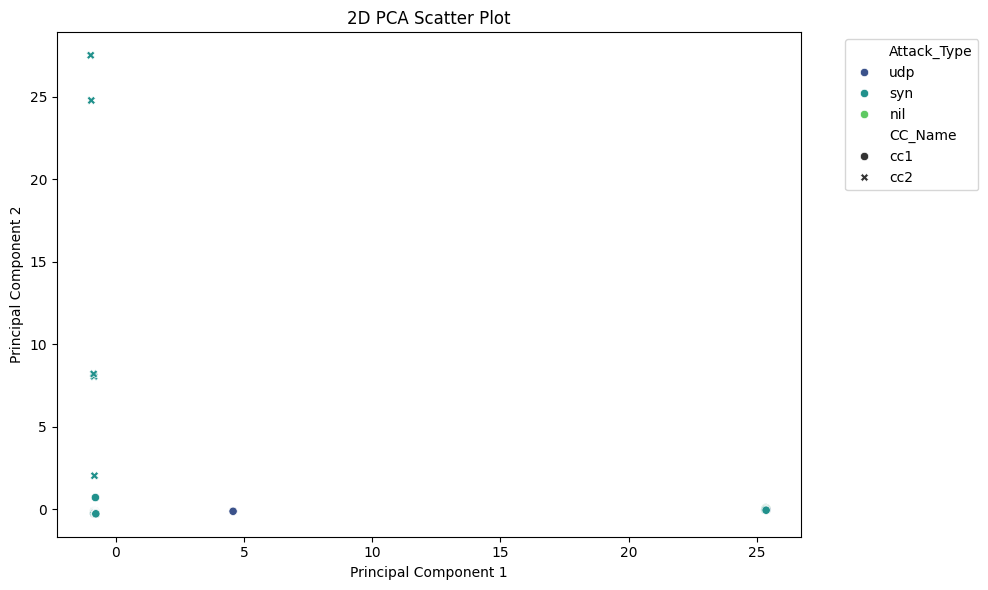

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', 
    y='PCA2', 
    hue='Attack_Type', 
    style='CC_Name', 
    data=pca_df, 
    palette='viridis'
)
plt.title('2D PCA Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()